# Phenotyping

In [1]:
import spatialdata
import opendvp
import pandas as pd

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Load data

In [15]:
sdata = spatialdata.read_zarr("../data/TNBC_subset/sdata_filtered.zarr")

In [16]:
sdata['imaging'].obs.index = sdata['imaging'].obs['CellID'].values.astype(str)
sdata['imaging'].obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,mean_DAPI_bg_above_6,mean_DAPI_bg_below_50,DNA_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,folded_tissue,Antibody_clumps,shapes
1,1,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,True,True,True,0.065991,False,True,False,False,False,mask_polygons
2,2,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,True,True,True,0.107462,False,True,False,False,False,mask_polygons
3,3,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,True,True,True,0.098039,False,True,False,False,False,mask_polygons
4,4,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,True,True,True,0.136228,False,True,False,False,False,mask_polygons
5,5,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,True,True,True,0.104794,False,True,False,False,False,mask_polygons


## The goal is to obtain a new column on the sdata['imaging'].obs dataframe with celltype label

The procedure:
1. Create phenotype matrix with markers with correct prioritizations
2. Define threshold for each marker for each sample via Napari plugin interface
3. Use those thresholds to scale the data to create pseudo binomial data
4. Phenotype cells
5. Perform QC

### Create phenotype matrix, as described in scimap

In [17]:
# check marker list
sdata['imaging'].var

,math,marker
mean_750_bg,mean,750_bg
mean_647_bg,mean,647_bg
mean_555_bg,mean,555_bg
mean_488_bg,mean,488_bg
mean_DAPI_bg,mean,DAPI_bg
mean_Vimentin,mean,Vimentin
mean_CD3e,mean,CD3e
mean_panCK,mean,panCK
mean_CD8,mean,CD8
mean_DAPI_1,mean,DAPI_1


## Threshold with napari

In [ ]:
# recommendation
# sometimes the images have biases per marker, that one would like to remove manually, after labelling
# I like using Qupath in parallel to annotate such regions, and use them to nullify signal artificially

In [18]:
#label imaging table with annotations
path_to_annotations = "../data/TNBC_subset/geojsons/20250205_TNBC_subset_annotations.geojson"

In [13]:
from opendvp import filtering

2025-03-10 11:27:45.429 | INFO     | opendvp.filtering:filter_by_annotation:144 -  ---- filter_by_annotation : version number 2.0.1 ----
2025-03-10 11:27:45.430 | INFO     | opendvp.filtering:filter_by_annotation:145 -  Each class of annotation will be a different column in adata.obs
2025-03-10 11:27:45.431 | INFO     | opendvp.filtering:filter_by_annotation:146 -  TRUE means cell was inside annotation, FALSE means cell not in annotation
2025-03-10 11:27:45.440 | INFO     | opendvp.filtering:filter_by_annotation:153 - GeoJson loaded, detected: 10 annotations


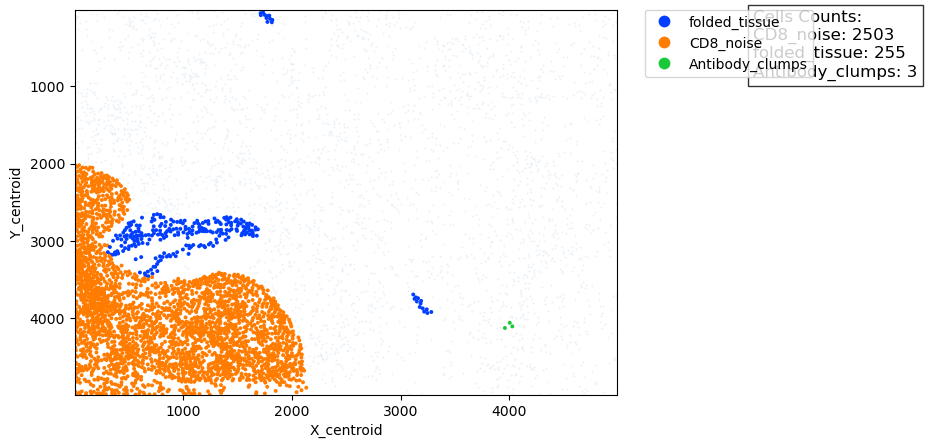

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning: Key `imaging` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [19]:
sdata['imaging'] = filtering.filter_by_annotation(sdata['imaging'], path_to_annotations).copy()

In [20]:
sdata['imaging'].obs.iloc[:5,-5:]

,shapes,folded_tissue_y,CD8_noise,Antibody_clumps_y,artefact
0,mask_polygons,False,False,False,False
1,mask_polygons,False,False,False,False
2,mask_polygons,False,False,False,False
3,mask_polygons,False,False,False,False
4,mask_polygons,False,False,False,False


### Cells are labelled with annotations

Lets reduce the CD8 value for cells labelled with CD8_noise

In [22]:
from opendvp import phenotyping

In [23]:
sdata['imaging'] = phenotyping.negate_var_by_ann(
    adata=sdata['imaging'],
    target_variable = "mean_CD8",
    target_annotation_column="CD8_noise",
    quantile_for_imputation=0.05
    )

2025-03-10 11:28:51.792 | INFO     | opendvp.phenotyping:negate_var_by_ann:58 - Imputing with 0.05% percentile value = 6.356338284753363
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning: Key `imaging` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [58]:
# spillover is inevitable
# see how these cells, marked as positive for CD3e also have pink signal (CD20). 
# Ideally pink and green does not overlap, and ideally the segmentation masks are perfect
# We can adress this in the phenotyping matrix

In [25]:
#store gates in the varm of sdata['imaging']
gates = pd.read_csv("../data/TNBC_subset/gating_folder/gates.csv")
gates.index = gates['marker_id'].values
sdata['imaging'].varm['gates'] = gates
sdata['imaging']

AnnData object with n_obs × n_vars = 16808 × 15
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'mean_DAPI_bg_above_6', 'mean_DAPI_bg_below_50', 'DNA_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'folded_tissue_x', 'Antibody_clumps_x', 'shapes', 'folded_tissue_y', 'CD8_noise', 'Antibody_clumps_y', 'artefact'
    var: 'math', 'marker'
    uns: 'spatialdata_attrs'
    varm: 'gates'

In [26]:
sdata['imaging'].varm['gates'].iloc[5:10,:]

,sample_id,marker_id,gate_value
mean_Vimentin,TD_15_TNBC_subset,mean_Vimentin,5.792953
mean_CD3e,TD_15_TNBC_subset,mean_CD3e,7.489209
mean_panCK,TD_15_TNBC_subset,mean_panCK,2.625427
mean_CD8,TD_15_TNBC_subset,mean_CD8,17.000000
mean_DAPI_1,TD_15_TNBC_subset,mean_DAPI_1,0.000000


In [27]:
gates = phenotyping.read_gates("../data/TNBC_subset/gating_folder/gates.csv", sample_id="TD_15_TNBC_subset")

2025-03-10 11:29:12.481 | INFO     | opendvp.phenotyping:read_gates:12 -  ---- read_gates : version number 1.1.0 ----
2025-03-10 11:29:12.484 | INFO     | opendvp.phenotyping:read_gates:18 -    Filtering out all rows with value 0.0 (assuming not gated)
2025-03-10 11:29:12.485 | INFO     | opendvp.phenotyping:read_gates:21 -   Found 8 valid gates
2025-03-10 11:29:12.486 | INFO     | opendvp.phenotyping:read_gates:22 -   Markers found: ['mean_Vimentin' 'mean_CD3e' 'mean_panCK' 'mean_CD8' 'mean_COL1A1'
 'mean_CD20' 'mean_CD68' 'mean_Ki67']
2025-03-10 11:29:12.487 | INFO     | opendvp.phenotyping:read_gates:23 -   Samples found: ['TD_15_TNBC_subset']
2025-03-10 11:29:12.488 | INFO     | opendvp.phenotyping:read_gates:28 -   Found 8 valid gates for sample TD_15_TNBC_subset
2025-03-10 11:29:12.488 | INFO     | opendvp.phenotyping:read_gates:30 -  ---- read_gates is done, took 0s  ----


In [28]:
gates

,sample_id,marker_id,gate_value
5,TD_15_TNBC_subset,mean_Vimentin,5.792953
6,TD_15_TNBC_subset,mean_CD3e,7.489209
7,TD_15_TNBC_subset,mean_panCK,2.625427
8,TD_15_TNBC_subset,mean_CD8,17.000000
10,TD_15_TNBC_subset,mean_COL1A1,22.791602
11,TD_15_TNBC_subset,mean_CD20,23.663612
12,TD_15_TNBC_subset,mean_CD68,3.206269
13,TD_15_TNBC_subset,mean_Ki67,1.984266


In [30]:
gates_for_scimap = phenotyping.process_gates_for_sm(gates, sample_id="TD_15_TNBC_subset")
gates_for_scimap

2025-03-10 11:33:15.503 | INFO     | opendvp.phenotyping:process_gates_for_sm:35 -  ---- process_gates_for_sm : version number 1.2.0 ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/phenotyping.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gates_for_scimap.rename(columns={'marker_id': 'markers', 'log1p_gate_value': sample_id}, inplace=True)
2025-03-10 11:33:15.509 | INFO     | opendvp.phenotyping:process_gates_for_sm:44 -  ---- process_gates_for_sm is done, took 0s  ----


,markers,TD_15_TNBC_subset
5,mean_Vimentin,1.915886
6,mean_CD3e,2.138796
7,mean_panCK,1.287972
8,mean_CD8,2.890372
10,mean_COL1A1,3.169333
11,mean_CD20,3.205329
12,mean_CD68,1.436576
13,mean_Ki67,1.093354


In [31]:
# we have to add sample id to adata obs
sdata['imaging'].obs['imageid'] = "TD_15_TNBC_subset"

In [32]:
#create filtered adata
adata_for_gating = sdata['imaging'][:, sdata['imaging'].var_names.isin(gates_for_scimap['markers'])].copy()
adata_for_gating

AnnData object with n_obs × n_vars = 16808 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'mean_DAPI_bg_above_6', 'mean_DAPI_bg_below_50', 'DNA_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'folded_tissue_x', 'Antibody_clumps_x', 'shapes', 'folded_tissue_y', 'CD8_noise', 'Antibody_clumps_y', 'artefact', 'imageid'
    var: 'math', 'marker'
    uns: 'spatialdata_attrs'
    varm: 'gates'

In [33]:
import pandas as pd
import numpy as np
import argparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
import anndata as ad
import json

In [34]:
def rescale(
    adata,
    gate=None,
    log=True,
    imageid='imageid',
    failed_markers=None,
    method='all',
    verbose=True,
    random_state=0,
    gmm_components=3,
):
    """
    Parameters:
        adata (AnnData Object, required):
            An annotated data object that contains single-cell expression data.

        gate (DataFrame, optional):
            A pandas DataFrame where the first column lists markers, and subsequent columns contain gate values
            for each image in the dataset. Column names must correspond to unique `imageid` identifiers, and the marker column must be named "markers".
            If a single column of gate values is provided for a dataset with multiple images, the same gate will be uniformly applied to all images.
            In this case, ensure that the columns are named exactly "markers" and "gates".
            If no gates are provided for specific markers, the function attempts to automatically determine gates using a Gaussian Mixture Model (GMM).

            Note: If you have used `napariGater()`, the gates are stored within `adata.uns['gates']`.
            You can directly pass `adata.uns['gates']` to use these pre-defined gates.

        log (bool, optional):
            If `True`, the data in `adata.raw.X` will be log-transformed (using log1p) before gate application. This transformation is recommended when automatic gate identification through GMM is performed, as it helps in normalizing data distributions.

        imageid (str, optional):
            The name of the column in `adata` that contains Image IDs. This is necessary for matching manual gates specified in the `gate` DataFrame to their respective images.

        failed_markers (dict, optional):
            A dictionary mapping `imageid` to markers that failed quality control. This allows for the exclusion of specific markers from the analysis based on prior visual inspection or other criteria. The dictionary can use `all` as a key to specify markers that failed across all images.

        method (str, optional):
            Specifies the gating strategy: `all` to pool data from all images for GMM application, or `by_image` to apply GMM separately for each image. `all` may introduce batch effects, while `by_image` requires sufficient variation within each image to distinguish negative from positive populations effectively.

        random_state (int, optional):
            The seed used by the random number generator for GMM. Ensures reproducibility of results.

        verbose (bool, optional):
            If `True`, detailed progress updates and diagnostic messages will be printed during the function's execution.

        gmm_components (int, optional):
            Number of components to use in the Gaussian Mixture Model for automatic gating.
            Must be at least 2. Gate will be placed between the highest two components.
            Default is 3.

    Returns:
        Modified AnnData Object (AnnData):
            Returns the input `adata` object with updated expression data (`adata.X`) after rescaling. The gates applied, either provided manually or determined automatically, are stored within `adata.uns['gates']`.

    Example:
        ```python

        # Example with manual gates
        manual_gate = pd.DataFrame({'marker': ['CD3D', 'KI67'], 'gate': [7, 8]})
        adata = sm.pp.rescale(adata, gate=manual_gate, failed_markers={'all': ['CD20', 'CD21']})

        # Importing gates from a CSV
        manual_gate = pd.read_csv('manual_gates.csv')
        adata = sm.pp.rescale(adata, gate=manual_gate, failed_markers={'all': ['CD20', 'CD21']})

        # Running without manual gates to use GMM for automatic gate determination
        adata = sm.pp.rescale(adata, gate=None, failed_markers={'all': ['CD20', 'CD21']})

        ```

    """

    # log=True; imageid='imageid'; failed_markers=None; method='all'; random_state=0

    # make a copy to raw data if raw is none
    if adata.raw is None:
        adata.raw = adata

    # Mapping between markers and gates in the given dataset
    dataset_markers = adata.var.index.tolist()
    dataset_images = adata.obs[imageid].unique().tolist()
    m = pd.DataFrame(index=dataset_markers, columns=dataset_images).reset_index()
    m = pd.melt(m, id_vars=[m.columns[0]])
    m.columns = ['markers', 'imageid', 'gate']

    # Manipulate m with and without provided manual gates
    if gate is None:
        gate_mapping = m.copy()
    else:
        # Check overlap between gate columns and dataset images
        matching_images = set(gate.columns) & set(dataset_images)

        # link to make sure index name is markers as we use reset_index later
        if gate.index.name != 'markers' and 'markers' not in gate.columns:
            gate.index.name = 'markers'

        if len(matching_images) == 0 and len(gate.columns) > 0:
            # Case 1: No matching images and single value column - apply globally
            gate = gate.reset_index()  # Convert index to column
            gate_mapping = m.copy()
            gate_mapping.gate = gate_mapping.gate.fillna(
                gate_mapping.markers.map(
                    dict(
                        zip(gate['markers'], gate['gates'])
                    )  # these columns are hardcoded in CSV
                )
            )
        else:
            # Case 2: handles both if all imageid matches with gate columns or if they partially match
            gate = gate.reset_index()
            manual_m = pd.melt(gate, id_vars=gate[['markers']])
            manual_m.columns = ['markers', 'imageid', 'm_gate']
            gate_mapping = pd.merge(
                m,
                manual_m,
                how='left',
                left_on=['markers', 'imageid'],
                right_on=['markers', 'imageid'],
            )
            gate_mapping['gate'] = gate_mapping['gate'].fillna(gate_mapping['m_gate'])
            gate_mapping = gate_mapping.drop(columns='m_gate')

    # Addressing failed markers
    def process_failed(adata_subset, foramted_failed_markers):
        if verbose:
            print(
                'Processing Failed Marker in '
                + str(adata_subset.obs[imageid].unique()[0])
            )
        # prepare data
        data_subset = pd.DataFrame(
            adata_subset.raw.X,
            columns=adata_subset.var.index,
            index=adata_subset.obs.index,
        )
        if log is True:
            data_subset = np.log1p(data_subset)

        # subset markers in the subset
        fm_sub = foramted_failed_markers[adata_subset.obs[imageid].unique()].dropna()

        def process_failed_internal(fail_mark, data_subset):
            return data_subset[fail_mark].max()

        r_process_failed_internal = lambda x: process_failed_internal(
            fail_mark=x, data_subset=data_subset
        )
        f_g = list(map(r_process_failed_internal, [x[0] for x in fm_sub.values]))
        subset_gate = pd.DataFrame(
            {
                'markers': [x[0] for x in fm_sub.values],
                'imageid': adata_subset.obs[imageid].unique()[0],
                'gate': f_g,
            }
        )
        # return
        return subset_gate

    # Identify the failed markers
    if failed_markers is not None:
        # check if failed marker is a dict
        if isinstance(failed_markers, dict) is False:
            raise ValueError(
                '`failed_markers` should be a python dictionary, please refer documentation'
            )
        # create a copy
        fm = failed_markers.copy()
        # seperate all from the rest
        if 'all' in failed_markers:
            all_failed = failed_markers['all']
            if isinstance(all_failed, str):
                all_failed = [all_failed]
            failed_markers.pop('all', None)

            df = pd.DataFrame(columns=adata.obs[imageid].unique())
            for i in range(len(all_failed)):
                df.loc[i] = np.repeat(all_failed[i], len(df.columns))
            # for i in  range(len(df.columns)):
            #    df.loc[i] = all_failed[i]
        # rest of the failed markers
        # fail = pd.DataFrame.from_dict(failed_markers)
        fail = pd.DataFrame(
            dict([(k, pd.Series(v)) for k, v in failed_markers.items()])
        )
        # merge
        if 'all' in fm:
            foramted_failed_markers = pd.concat([fail, df], axis=0)
        else:
            foramted_failed_markers = fail

        # send the adata objects that need to be processed
        # Check if any image needs to pass through the GMM protocol
        adata_list = [
            adata[adata.obs[imageid] == i] for i in foramted_failed_markers.columns
        ]
        # apply the process_failed function
        r_process_failed = lambda x: process_failed(
            adata_subset=x, foramted_failed_markers=foramted_failed_markers
        )
        failed_gates = list(map(r_process_failed, adata_list))
        # combine the results and merge with gate_mapping
        result = []
        for i in range(len(failed_gates)):
            result.append(failed_gates[i])
        result = pd.concat(result, join='outer')
        # use this to merge with gate_mapping
        x1 = gate_mapping.set_index(['markers', 'imageid'])['gate']
        x2 = result.set_index(['markers', 'imageid'])['gate']
        x1.update(x2)
        gate_mapping = x1.reset_index()

    # trim the data before applying GMM
    def clipping(x):
        clip = x.clip(
            lower=np.percentile(x, 0.01), upper=np.percentile(x, 99.99)
        ).tolist()
        return clip

    # Find GMM based gates
    def gmm_gating(marker, data, gmm_components):
        """Internal function to identify gates using GMM

        Parameters:
            marker: marker name
            data: expression data
            gmm_components: number of components for GMM (minimum 2)
        """
        # Ensure minimum of 2 components
        gmm_components = max(2, gmm_components)

        # Prepare data for GMM
        data_gm = data[marker].values.reshape(-1, 1)
        data_gm = data_gm[~np.isnan(data_gm), None]

        # Fit GMM with gmm_components
        gmm = GaussianMixture(
            n_components=gmm_components, random_state=random_state
        ).fit(data_gm)

        # Sort components by their means
        means = gmm.means_.flatten()
        sorted_idx = np.argsort(means)
        sorted_means = means[sorted_idx]

        # Calculate gate as midpoint between the second-to-last and last components
        gate = np.mean([sorted_means[-2], sorted_means[-1]])

        return gate

    # Running gmm_gating on the dataset
    def gmm_gating_internal(adata_subset, gate_mapping, method):
        return result

    # Create a list of image IDs that need to go through the GMM
    gmm_images = gate_mapping[gate_mapping.gate.isnull()].imageid.unique()

    # Check if any image needs to pass through the GMM protocol
    if len(gmm_images) > 0:
        # Create a list of adata that need to go through the GMM
        if method == 'all':
            adata_list = [adata]
        else:
            adata_list = [adata[adata.obs[imageid] == i] for i in gmm_images]
        # run function
        r_gmm_gating_internal = lambda x: gmm_gating_internal(
            adata_subset=x, gate_mapping=gate_mapping, method=method
        )
        all_gates = list(map(r_gmm_gating_internal, adata_list))

        # combine the results and merge with gate_mapping
        result = []
        for i in range(len(all_gates)):
            result.append(all_gates[i])
        result = pd.concat(result, join='outer')
        # use this to merge with gate_mapping
        gate_mapping.gate = gate_mapping.gate.fillna(
            gate_mapping.markers.map(dict(zip(result.markers, result.gate)))
        )

    # Rescaling function
    def data_scaler(adata_subset, gate_mapping):
        if verbose:
            print('\nScaling Image: ' + str(adata_subset.obs[imageid].unique()[0]))
        # Organise data
        data_subset = pd.DataFrame(
            adata_subset.raw.X,
            columns=adata_subset.var.index,
            index=adata_subset.obs.index,
        )
        if log is True:
            data_subset = np.log1p(data_subset)
        # subset markers in the subset
        gate_mapping_sub = gate_mapping[
            gate_mapping['imageid'] == adata_subset.obs[imageid].unique()[0]
        ]

        # organise gates
        def data_scaler_internal(marker, gate_mapping_sub):
            if verbose:
                gate_value = gate_mapping_sub[gate_mapping_sub.markers == marker][
                    'gate'
                ].values[0]
                print(f'Scaling {marker} (gate: {gate_value:.3f})')
            # find the gate
            moi = gate_mapping_sub[gate_mapping_sub.markers == marker]['gate'].values[0]

            # Find the closest value to the gate
            absolute_val_array = np.abs(data_subset[marker].values - float(moi))
            # throw error if the array has nan values
            if np.isnan(absolute_val_array).any():
                raise ValueError(
                    "An exception occurred: " + str(marker) + ' has nan values'
                )
            # smallest diff
            smallest_difference_index = absolute_val_array.argmin()
            closest_element = data_subset[marker].values[smallest_difference_index]

            # rescale the data based on the identified gate
            marker_study = data_subset[marker]
            marker_study = marker_study.sort_values(axis=0)
            # Find the index of the gate
            # account for 0
            if all(marker_study == 0):
                gate_index = pd.DataFrame(marker_study).tail(2).index[0]
            else:
                gate_index = marker_study.index[marker_study == closest_element][0]
            # Split into high and low groups
            high = marker_study[gate_index:]
            low = marker_study[:gate_index]
            # Prepare for scaling the high and low dataframes
            scaler_high = MinMaxScaler(feature_range=(0.5, 1))
            scaler_low = MinMaxScaler(feature_range=(0, 0.5))
            # Scale it
            h = pd.DataFrame(
                scaler_high.fit_transform(high.values.reshape(-1, 1)), index=high.index
            )
            l = pd.DataFrame(
                scaler_low.fit_transform(low.values.reshape(-1, 1)), index=low.index
            )
            # Merge the high and low and resort it
            scaled_data = pd.concat([l, h])
            scaled_data = scaled_data.loc[~scaled_data.index.duplicated(keep='first')]
            scaled_data = scaled_data.reindex(data_subset.index)
            # scaled_data[scaled_data > 0.5].count(axis=1).sum()
            # return
            return scaled_data

        # run internal function
        r_data_scaler_internal = lambda x: data_scaler_internal(
            marker=x, gate_mapping_sub=gate_mapping_sub
        )
        scaled_subset = list(
            map(r_data_scaler_internal, gate_mapping_sub.markers.values)
        )

        # combine the results and merge with gate_mapping
        scaled_subset_result = []
        for i in range(len(scaled_subset)):
            scaled_subset_result.append(scaled_subset[i])
        scaled_subset_result = pd.concat(scaled_subset_result, join='outer', axis=1)
        scaled_subset_result.columns = gate_mapping_sub.markers.values
        # scaled_subset_result[scaled_subset_result['CD3E'] > 0.5]['CD3E'].count(axis=1).sum()

        # return
        return scaled_subset_result

    # pass each dataset seperately
    adata_list = [adata[adata.obs[imageid] == i] for i in adata.obs[imageid].unique()]

    # Run the scaler function
    r_data_scaler = lambda x: data_scaler(adata_subset=x, gate_mapping=gate_mapping)
    scaled_subset = list(map(r_data_scaler, adata_list))

    # combine the results and merge with gate_mapping
    final_result = []
    for i in range(len(scaled_subset)):
        final_result.append(scaled_subset[i])
    final_result = pd.concat(final_result, join='outer')

    # reindex the final_results
    final_result = final_result.reindex(adata.obs.index)

    # save final gates
    adata.uns['gates'] = gate_mapping.pivot_table(
        index=['markers'], columns=['imageid']
    ).droplevel(
        0, axis=1
    )  # .reset_index()

    # add to the anndata
    adata.X = final_result

    # return adata
    return adata

In [35]:
rescaled_adata_for_gating = rescale(
    adata_for_gating, 
    gate=gates_for_scimap, 
    method='all')


Scaling Image: TD_15_TNBC_subset
Scaling mean_Vimentin (gate: 1.916)
Scaling mean_CD3e (gate: 2.139)
Scaling mean_panCK (gate: 1.288)
Scaling mean_CD8 (gate: 2.890)
Scaling mean_COL1A1 (gate: 3.169)
Scaling mean_CD20 (gate: 3.205)
Scaling mean_CD68 (gate: 1.437)
Scaling mean_Ki67 (gate: 1.093)


/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_60780/4165269131.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gate_mapping['gate'] = gate_mapping['gate'].fillna(gate_mapping['m_gate'])


In [36]:
# load the phenotyping workflow
phenotype = pd.read_csv('../data/TNBC_subset/Phenotype_Matrix_TNBC.csv')
phenotype.style.format(na_rep='')

,Unnamed: 0,Unnamed: 1,Vimentin,CD3e,panCK,CD8,COL1A1,CD20,CD68,Ki67
0,all,Epithelial,,,pos,,,,,
1,all,Mesenchymal,pos,,,,,,,
2,all,Immune,,anypos,,anypos,,anypos,anypos,
3,all,Fibroblasts,,,,,pos,,,
4,Immune,CD4_T_cell,,pos,,neg,,,,
5,Immune,CD8_T_cell,,,,pos,,,,
6,Immune,B_cell,,,,,,pos,,
7,Immune,Macrophage,,,,,,,pos,


In [37]:
def phenotype_cells (adata, 
                     phenotype, 
                     gate = 0.5, 
                     label="phenotype", 
                     imageid='imageid',
                     pheno_threshold_percent=None, 
                     pheno_threshold_abs=None,
                     verbose=True
                     ):
    """
    
Parameters:
    adata (anndata.AnnData):  
        The input AnnData object containing single-cell data for phenotyping.

    phenotype (pd.DataFrame):  
        A DataFrame specifying the gating strategy for cell phenotyping. It should outline the workflow for phenotype classification based on marker expression levels. An example workflow is available at [this GitHub link](https://github.com/ajitjohnson/scimap/blob/master/scimap/tests/_data/phenotype_workflow.csv).
        
    gate (float, optional):  
        The threshold value for determining positive cell classification based on scaled data. By convention, values above this threshold are considered to indicate positive cells. 
        
    label (str):  
        The name of the column in `adata.obs` where the final phenotype classifications will be stored. This label will be used to access the phenotyping results within the `AnnData` object.
        
    imageid (str, optional):  
        The name of the column in `adata.obs` that contains unique image identifiers. This is crucial for analyses that require differentiation of data based on the source image, especially when using phenotype threshold parameters (`pheno_threshold_percent` or `pheno_threshold_abs`).
        
    pheno_threshold_percent (float, optional):  
        A threshold value (between 0 and 100) specifying the minimum percentage of cells that must exhibit a particular phenotype for it to be considered valid. Phenotypes not meeting this threshold are reclassified as 'unknown'. This parameter is useful for minimizing the impact of low-frequency false positives. 
        
    pheno_threshold_abs (int, optional):  
        Similar to `pheno_threshold_percent`, but uses an absolute cell count instead of a percentage. Phenotypes with cell counts below this threshold are reclassified as 'unknown'. This can help in addressing rare phenotype classifications that may not be meaningful. 
    
    verbose (bool):  
        If set to `True`, the function will print detailed messages about its progress and the steps being executed.

Returns:
    adata (anndata.AnnData):  
        The input AnnData object, updated to include the phenotype classifications for each cell. The phenotyping results can be found in `adata.obs[label]`, where `label` is the name specified by the user for the phenotype column.

Example:    
    ```python
    
    # Load the phenotype workflow CSV file
    phenotype = pd.read_csv('path/to/csv/file/')  
    
    # Apply phenotyping to cells based on the specified workflow
    adata = sm.tl.phenotype_cells(adata, phenotype=phenotype, gate=0.5, label="phenotype")
    
    ```

    """
    # Create a dataframe from the adata object
    data = pd.DataFrame(adata.X, columns = adata.var.index, index= adata.obs.index)

    # Function to calculate the phenotype scores
    def phenotype_cells (data,phenotype,gate,group):

        # Subset the phenotype based on the group
        phenotype = phenotype[phenotype.iloc[:,0] == group]

        # Parser to parse the CSV file into four categories
        def phenotype_parser (p, cell):
            # Get the index and subset the phenotype row being passed in
            location = p.iloc[:,1] == cell
            idx = [i for i, x in enumerate(location) if x][0]
            phenotype = p.iloc[idx,:]
            # Calculate
            pos = phenotype[phenotype == 'pos'].index.tolist()
            neg = phenotype[phenotype == 'neg'].index.tolist()
            anypos = phenotype[phenotype == 'anypos'].index.tolist()
            anyneg = phenotype[phenotype == 'anyneg'].index.tolist()
            allpos = phenotype[phenotype == 'allpos'].index.tolist()
            allneg = phenotype[phenotype == 'allneg'].index.tolist()
            return {'pos': pos, 'neg': neg ,'anypos': anypos, 'anyneg': anyneg, 'allpos': allpos, 'allneg': allneg}
            #return pos, neg, anypos, anyneg

        # Run the phenotype_parser function on all rows
        p_list = phenotype.iloc[:,1].tolist()
        r_phenotype = lambda x: phenotype_parser(cell=x, p=phenotype) # Create lamda function
        all_phenotype = list(map(r_phenotype, p_list)) # Apply function
        all_phenotype = dict(zip(p_list, all_phenotype)) # Name the lists

        # Define function to check if there is any marker that does not satisfy the gate
        def gate_satisfation_lessthan (marker, data, gate):
            fail = np.where(data[marker] < gate, 1, 0) # 1 is fail
            return fail
        # Corresponding lamda function
        r_gate_satisfation_lessthan = lambda x: gate_satisfation_lessthan(marker=x, data=data, gate=gate)

        # Define function to check if there is any marker that does not satisfy the gate
        def gate_satisfation_morethan (marker, data, gate):
            fail = np.where(data[marker] > gate, 1, 0)
            return fail
        # Corresponding lamda function
        r_gate_satisfation_morethan = lambda x: gate_satisfation_morethan(marker=x, data=data, gate=gate)

        def prob_mapper (data, all_phenotype, cell, gate):
            
            if verbose:
                print("Phenotyping " + str(cell))

            # Get the appropriate dict from all_phenotype
            p = all_phenotype[cell]

            # Identiy the marker used in each category
            pos = p.get('pos')
            neg = p.get('neg')
            anypos = p.get('anypos')
            anyneg = p.get('anyneg')
            allpos = p.get('allpos')
            allneg = p.get('allneg')

            # Perform computation for each group independently
            # Positive marker score
            if len(pos) != 0:
                pos_score = data[pos].mean(axis=1).values
                pos_fail = list(map(r_gate_satisfation_lessthan, pos)) if len(pos) > 1 else []
                pos_fail = np.amax(pos_fail, axis=0) if len(pos) > 1 else []
            else:
                pos_score = np.repeat(0, len(data))
                pos_fail = []

            # Negative marker score
            if len(neg) != 0:
                neg_score = (1-data[neg]).mean(axis=1).values
                neg_fail = list(map(r_gate_satisfation_morethan, neg)) if len(neg) > 1 else []
                neg_fail = np.amax(neg_fail, axis=0) if len(neg) > 1 else []
            else:
                neg_score = np.repeat(0, len(data))
                neg_fail = []

            # Any positive score
            anypos_score = np.repeat(0, len(data)) if len(anypos) == 0 else data[anypos].max(axis=1).values

            # Any negative score
            anyneg_score = np.repeat(0, len(data)) if len(anyneg) == 0 else (1-data[anyneg]).max(axis=1).values

            # All positive score
            if len(allpos) != 0:
                allpos_score = data[allpos]
                allpos_score['score'] = allpos_score.max(axis=1)
                allpos_score.loc[(allpos_score < gate).any(axis = 1), 'score'] = 0
                allpos_score = allpos_score['score'].values + 0.01 # A small value is added to give an edge over the matching positive cell
            else:
                allpos_score = np.repeat(0, len(data))


            # All negative score
            if len(allneg) != 0:
                allneg_score = 1- data[allneg]
                allneg_score['score'] = allneg_score.max(axis=1)
                allneg_score.loc[(allneg_score < gate).any(axis = 1), 'score'] = 0
                allneg_score = allneg_score['score'].values + 0.01
            else:
                allneg_score = np.repeat(0, len(data))


            # Total score calculation
            # Account for differences in the number of categories used for calculation of the final score
            number_of_non_empty_features = np.sum([len(pos) != 0,
                                                len(neg) != 0,
                                                len(anypos) != 0,
                                                len(anyneg) != 0,
                                                len(allpos) != 0,
                                                len(allneg) != 0])

            total_score = (pos_score + neg_score + anypos_score + anyneg_score + allpos_score + allneg_score) / number_of_non_empty_features

            return {cell: total_score, 'pos_fail': pos_fail ,'neg_fail': neg_fail}
            #return total_score, pos_fail, neg_fail


        # Apply the fuction to get the total score for all cell types
        r_prob_mapper = lambda x: prob_mapper (data=data, all_phenotype=all_phenotype, cell=x, gate=gate) # Create lamda function
        final_scores = list(map(r_prob_mapper, [*all_phenotype])) # Apply function
        final_scores = dict(zip([*all_phenotype], final_scores)) # Name the lists

        # Combine the final score to annotate the cells with a label
        final_score_df = pd.DataFrame()
        for i in [*final_scores]:
            df = pd.DataFrame(final_scores[i][i])
            final_score_df= pd.concat([final_score_df, df], axis=1)
        # Name the columns
        final_score_df.columns = [*final_scores]
        final_score_df.index = data.index
        # Add a column called unknown if all markers have a value less than the gate (0.5)
        unknown = group + str('-rest')
        final_score_df[unknown] = (final_score_df < gate).all(axis=1).astype(int)

        # Name each cell
        labels = final_score_df.idxmax(axis=1)

        # Group all failed instances (i.e. when multiple markers were given
        # any one of the marker fell into neg or pos zones of the gate)
        pos_fail_all = pd.DataFrame()
        for i in [*final_scores]:
            df = pd.DataFrame(final_scores[i]['pos_fail'])
            df.columns = [i] if len(df) != 0 else []
            pos_fail_all= pd.concat([pos_fail_all, df], axis=1)
        pos_fail_all.index = data.index if len(pos_fail_all) != 0 else []
        # Same for Neg
        neg_fail_all = pd.DataFrame()
        for i in [*final_scores]:
            df = pd.DataFrame(final_scores[i]['neg_fail'])
            df.columns = [i] if len(df) != 0 else []
            neg_fail_all= pd.concat([neg_fail_all, df], axis=1)
        neg_fail_all.index = data.index if len(neg_fail_all) != 0 else []


        # Modify the labels with the failed annotations
        if len(pos_fail_all) != 0:
            for i in pos_fail_all.columns:
                labels[(labels == i) & (pos_fail_all[i] == 1)] = 'likely-' + i
        # Do the same for negative
        if len(neg_fail_all) != 0:
            for i in neg_fail_all.columns:
                labels[(labels == i) & (neg_fail_all[i] == 1)] = 'likely-' + i

        # Retun the labels
        return labels

    # Create an empty dataframe to hold the labeles from each group
    phenotype_labels = pd.DataFrame()

    # Loop through the groups to apply the phenotype_cells function
    for i in phenotype.iloc[:,0].unique():

        if phenotype_labels.empty:
            phenotype_labels = pd.DataFrame(phenotype_cells(data = data, group = i, phenotype=phenotype, gate=gate))
            phenotype_labels.columns = [i]

        else:
            # Find the column with the cell-type of interest
            column_of_interest = [] # Empty list to hold the column name
            try:
                column_of_interest = phenotype_labels.columns[phenotype_labels.eq(i).any()]
            except:
                pass
            # If the cell-type of interest was not found just add NA
            if len(column_of_interest) == 0:
                phenotype_labels[i] = np.nan
            else:
                #cells_of_interest = phenotype_labels[phenotype_labels[column_of_interest] == i].index
                cells_of_interest = phenotype_labels[phenotype_labels[column_of_interest].eq(i).any(axis=1)].index
                d = data.loc[cells_of_interest]
                if verbose:
                    print("-- Subsetting " + str(i))
                phenotype_l = pd.DataFrame(phenotype_cells(data = d, group = i, phenotype=phenotype, gate=gate), columns = [i])
                phenotype_labels = phenotype_labels.merge(phenotype_l, how='outer', left_index=True, right_index=True)

    # Rearrange the rows back to original
    phenotype_labels = phenotype_labels.reindex(data.index)
    phenotype_labels = phenotype_labels.replace('-rest', np.nan, regex=True)

    if verbose:
        print("Consolidating the phenotypes across all groups")
    phenotype_labels_Consolidated = phenotype_labels.fillna(method='ffill', axis = 1)
    phenotype_labels[label] = phenotype_labels_Consolidated.iloc[:,-1].values

    # replace nan to 'other cells'
    phenotype_labels[label] = phenotype_labels[label].fillna('Unknown')

    # Apply the phenotype threshold if given
    if pheno_threshold_percent or pheno_threshold_abs is not None:
        p = pd.DataFrame(phenotype_labels[label])
        q = pd.DataFrame(adata.obs[imageid])
        p = q.merge(p, how='outer', left_index=True, right_index=True)

        # Function to remove phenotypes that are less than the given threshold
        def remove_phenotype(p, ID, pheno_threshold_percent, pheno_threshold_abs):
            d = p[p[imageid] == ID]
            x = pd.DataFrame(d.groupby([label]).size())
            x.columns = ['val']
            # FInd the phenotypes that are less than the given threshold
            if pheno_threshold_percent is not None:
                fail = list(x.loc[x['val'] < x['val'].sum() * pheno_threshold_percent/100].index)
            if pheno_threshold_abs is not None:
                fail = list(x.loc[x['val'] < pheno_threshold_abs].index)
            d[label] = d[label].replace(dict(zip(fail, ['Unknown'] * len(fail) )))
            # Return
            return d

        # Apply function to all images
        r_remove_phenotype = lambda x: remove_phenotype (p=p, ID=x,
                                                         pheno_threshold_percent=pheno_threshold_percent,
                                                         pheno_threshold_abs=pheno_threshold_abs) # Create lamda function
        final_phrnotypes= list(map(r_remove_phenotype, list(p[imageid].unique()))) # Apply function

        final_phrnotypes = pd.concat(final_phrnotypes, join='outer')
        phenotype_labels = final_phrnotypes.reindex(adata.obs.index)


    # Return to adata
    adata.obs[label] = phenotype_labels[label]

    #for i in phenotype_labels.columns:
    #    adata.obs[i] = phenotype_labels[i]

    return adata

In [38]:
rescaled_adata_for_gating.var

,math,marker
mean_Vimentin,mean,Vimentin
mean_CD3e,mean,CD3e
mean_panCK,mean,panCK
mean_CD8,mean,CD8
mean_COL1A1,mean,COL1A1
mean_CD20,mean,CD20
mean_CD68,mean,CD68
mean_Ki67,mean,Ki67


In [39]:
rescaled_adata_for_gating.var['feature_name']  = rescaled_adata_for_gating.var.index
rescaled_adata_for_gating.var.index = rescaled_adata_for_gating.var['marker']

In [40]:
adata_phenotyped = phenotype_cells(
    rescaled_adata_for_gating, 
    phenotype=phenotype, 
    label="phenotype",
    verbose=True) 

Phenotyping Epithelial
Phenotyping Mesenchymal
Phenotyping Immune
Phenotyping Fibroblasts
-- Subsetting Immune
Phenotyping CD4_T_cell
Phenotyping CD8_T_cell
Phenotyping B_cell
Phenotyping Macrophage
Consolidating the phenotypes across all groups


/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_60780/678436734.py:258: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  phenotype_labels_Consolidated = phenotype_labels.fillna(method='ffill', axis = 1)
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_60780/678436734.py:258: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  phenotype_labels_Consolidated = phenotype_labels.fillna(method='ffill', axis = 1)


In [41]:
adata_phenotyped.obs['phenotype'].value_counts()

phenotype
Epithelial     7766
Unknown        4070
CD4_T_cell     3159
Fibroblasts     830
Mesenchymal     655
CD8_T_cell      200
B_cell          112
Macrophage       16
Name: count, dtype: int64

In [42]:
sdata['imaging'].obs['phenotype'] = adata_phenotyped.obs['phenotype'].values

In [43]:
sdata['imaging'].obs.iloc[:5,-5:]

,CD8_noise,Antibody_clumps_y,artefact,imageid,phenotype
0,False,False,False,TD_15_TNBC_subset,Epithelial
1,False,False,False,TD_15_TNBC_subset,Epithelial
2,False,False,False,TD_15_TNBC_subset,Epithelial
3,False,False,False,TD_15_TNBC_subset,Epithelial
4,False,False,False,TD_15_TNBC_subset,Epithelial


In [44]:
sdata['imaging'].obs.index.name = 'cell_id'

In [51]:
sdata['imaging'].obs['phenotype'].isna().sum()

0

## Checkpoint

In [45]:
sdata.write("../data/TNBC_subset/sdata_phenotyped.zarr")

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside ../data/TNBC_subset/sdata_phenotyped.zarr). Please see the documentation of             
         `is_self_contained()` to understand the implications of working with SpatialData objects that are not     
         self-contained.                                                                                           
INFO     The Zarr backing store has been changed from ../data/TNBC_subset/sdata_filtered.zarr the new file path:   
         ../data/TNBC_subset/sdata_phenotyped.zarr                                                                 


# Quality Control

In [60]:
sdata = spatialdata.read_zarr("../data/TNBC_subset/sdata_phenotyped.zarr")

In [61]:
from opendvp import qupath_utils

In [81]:
import importlib

In [82]:
importlib.reload(qupath_utils)

<module 'opendvp.qupath_utils' from '/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/qupath_utils.py'>

In [62]:
import anndata as ad
import spatialdata
import geopandas
import xarray
from loguru import logger
from itertools import cycle
import shapely
import os

import dask_image.imread
import dask.array as da

In [63]:
sdata['mask_polygons']

,label,geometry
label,,
1,1,"POLYGON ((60 43.5, 59 43.5, 58 43.5, 57 43.5, ..."
2,2,"POLYGON ((134 19.5, 133 19.5, 132 19.5, 131 19..."
3,3,"POLYGON ((156 33.5, 155 33.5, 154 33.5, 153 33..."
4,4,"POLYGON ((188 13.5, 187 13.5, 186 13.5, 185 13..."
5,5,"POLYGON ((235 48.5, 234 48.5, 233 48.5, 232.5 ..."
...,...,...
16804,16804,"POLYGON ((133 5000.5, 132 5000.5, 131 5000.5, ..."
16805,16805,"POLYGON ((830 5000.5, 829 5000.5, 828 5000.5, ..."
16806,16806,"POLYGON ((671 5000.5, 670 5000.5, 669 5000.5, ..."


In [67]:
sdata['imaging'].obs.index =  sdata['imaging'].obs.CellID.values
sdata['imaging'].obs.index.name = "cellID"

In [68]:
sdata['imaging'].obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,...,DAPI_ratio_pass,folded_tissue_x,Antibody_clumps_x,shapes,folded_tissue_y,CD8_noise,Antibody_clumps_y,artefact,imageid,phenotype
cellID,,,,,,,,,,,,,,,,,,,,,
1,1,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,...,False,False,False,mask_polygons,False,False,False,False,TD_15_TNBC_subset,Epithelial
2,2,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,...,False,False,False,mask_polygons,False,False,False,False,TD_15_TNBC_subset,Epithelial
3,3,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,...,False,False,False,mask_polygons,False,False,False,False,TD_15_TNBC_subset,Epithelial
4,4,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,...,False,False,False,mask_polygons,False,False,False,False,TD_15_TNBC_subset,Epithelial
5,5,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,...,False,False,False,mask_polygons,False,False,False,False,TD_15_TNBC_subset,Epithelial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16804,16804,4993.579685,106.373030,571.0,52.291050,14.719719,0.959562,-1.563557,116.870058,0.976068,...,False,False,False,mask_polygons,False,True,False,True,TD_15_TNBC_subset,Epithelial
16805,16805,4993.413242,810.385845,438.0,40.105247,14.334812,0.933940,1.531591,90.970563,0.962637,...,True,False,False,mask_polygons,False,True,False,True,TD_15_TNBC_subset,Unknown
16806,16806,4994.153535,645.010101,495.0,50.864135,13.112118,0.966202,1.538209,111.248737,0.951923,...,False,False,False,mask_polygons,False,True,False,True,TD_15_TNBC_subset,Fibroblasts


In [79]:
sdata["mask_polygons"].index

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       16799, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807, 16808],
      dtype='int64', name='label', length=16808)

In [77]:
sdata["imaging"].obs["phenotype"].astype(str)

cellID
1         Epithelial
2         Epithelial
3         Epithelial
4         Epithelial
5         Epithelial
            ...     
16804     Epithelial
16805        Unknown
16806    Fibroblasts
16807        Unknown
16808        Unknown
Name: phenotype, Length: 16808, dtype: object

In [78]:
sdata['imaging'].obs.index.dtype

dtype('int64')

In [80]:
sdata["mask_polygons"].index.map(sdata["imaging"].obs["phenotype"]).astype(str)

Index(['Epithelial', 'Epithelial', 'Epithelial', 'Epithelial', 'Epithelial',
       'Epithelial', 'Epithelial', 'Epithelial', 'Unknown', 'CD4_T_cell',
       ...
       'Unknown', 'Unknown', 'CD4_T_cell', 'Fibroblasts', 'Epithelial',
       'Epithelial', 'Unknown', 'Fibroblasts', 'Unknown', 'Unknown'],
      dtype='object', name='label', length=16808)

In [73]:
key_to_shapes='mask_polygons'
export_path='../data/TNBC_subset/phenotyped_cells.geojson'
table_key='imaging'
classify_by='phenotype'

In [83]:
qupath_utils.sdata_to_qupath_detections(
    sdata,
    key_to_shapes='mask_polygons',
    export_path='../data/TNBC_subset/phenotyped_cells.geojson',
    table_key='imaging',
    classify_by='phenotype',
    
)

2025-03-10 11:59:46.829 | INFO     | opendvp.qupath_utils:sdata_to_qupath_detections:94 - Converting mask_polygons geodataframe to detections
2025-03-10 11:59:46.833 | INFO     | opendvp.qupath_utils:sdata_to_qupath_detections:117 - Check of inputs completed, starting conversion to detections
2025-03-10 11:59:46.834 | INFO     | opendvp.qupath_utils:sdata_to_qupath_detections:128 - Naming detections as cellID
2025-03-10 11:59:46.842 | INFO     | opendvp.qupath_utils:sdata_to_qupath_detections:132 - Labeling geometries as detections, for smooth viewing in QuPath
2025-03-10 11:59:46.842 | INFO     | opendvp.qupath_utils:sdata_to_qupath_detections:136 - Classifying detections by phenotype
2025-03-10 11:59:46.845 | INFO     | opendvp.qupath_utils:sdata_to_qupath_detections:137 - Classes found in table:
phenotype
Epithelial     7766
Unknown        4070
CD4_T_cell     3159
Fibroblasts     830
Mesenchymal     655
CD8_T_cell      200
B_cell          112
Macrophage       16
2025-03-10 11:59:46.

# Recurrent cellular neighborhoods

# Viz for paper

## Step 1: Phenotyped points 

## Step 2: Recurrent celullar neighborhoods